# Statistics
## Load packages

In [70]:
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import seaborn as sns

import warnings

from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

In [71]:
warnings.filterwarnings('ignore')

## Import data

In [72]:
# load data
df = pd.read_csv('Data_34.csv',encoding='utf-8')
df30 = df.head(30)
df30.head()

,Title,Status,Total Score,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度,穩定程度,評估,評估（考量台灣）
0,Avian Influenza A H10N3 in China,Low,23,3,3,1,1,2,1,3,3,1,3,2,Medium,Medium
1,Measles in Canada,Medium,20,2,3,3,3,3,1,1,1,1,1,1,High,Medium
2,Rabies in Timor Leste,Watchlist,27,3,3,3,3,1,3,3,1,3,2,2,High,Medium
3,Measles in United States,Medium,22,2,3,3,3,3,1,1,1,1,2,2,Medium,Medium
4,Avian Influenza in Vietnam,Low,26,3,3,2,2,2,3,3,3,2,2,1,Medium,Medium


In [ ]:
df30m = df30.iloc[:,3:13]
df30m.head()

## Correlation and Covariance

In [73]:
# 進行matplotlib繪圖時顯示繁體中文
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mp.rc('font', family='Taipei Sans TC Beta')

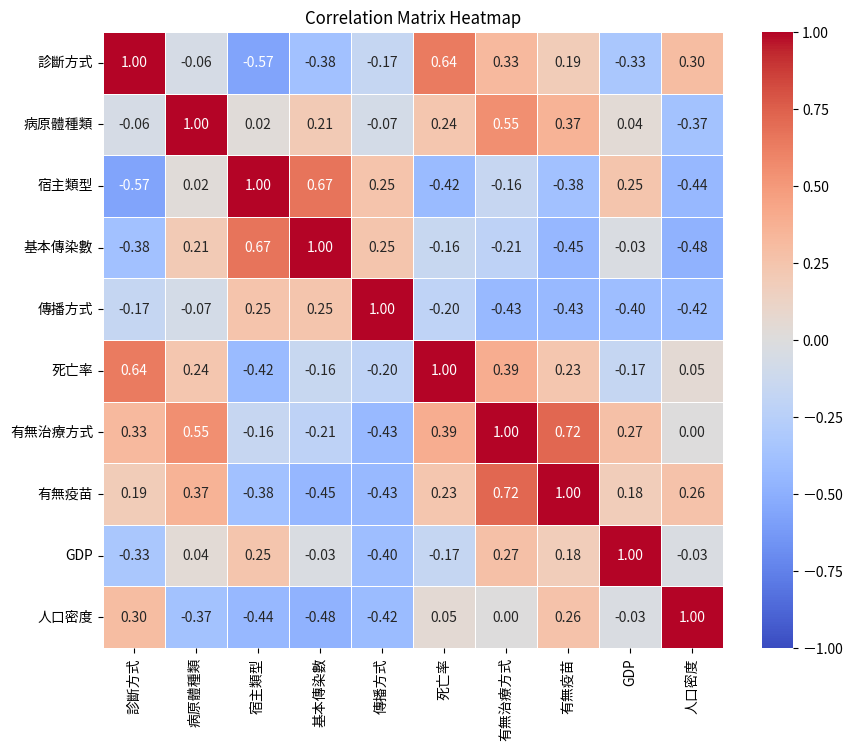

In [74]:
# correlation
df30m_cor = df30m.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df30m_cor, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

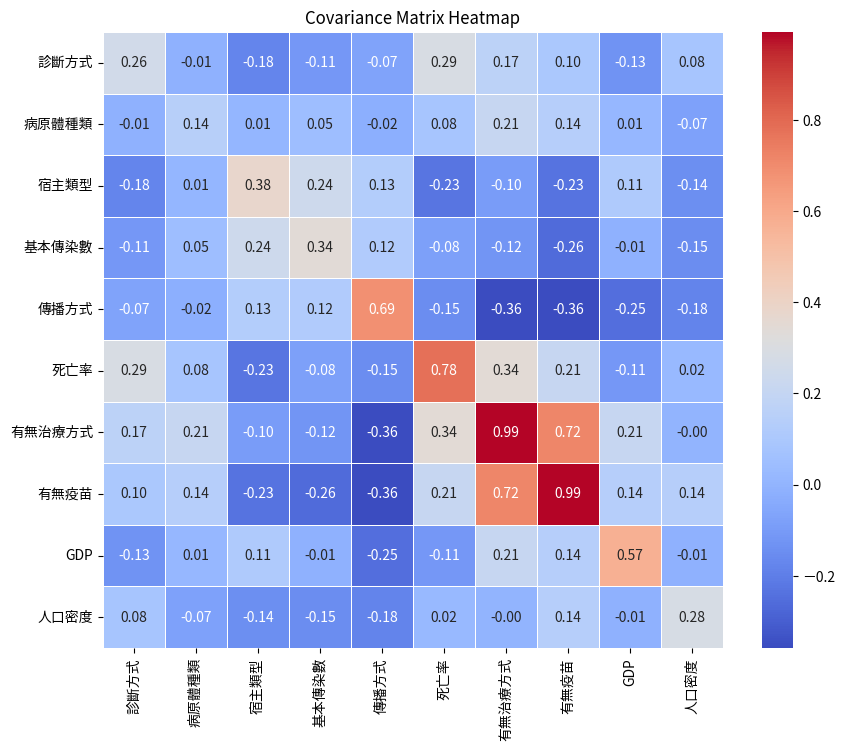

In [75]:
# covariance
df30m_cov = df30m.cov()
plt.figure(figsize=(10, 8))
sns.heatmap(df30m_cov, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()

## Train

In [76]:
df30['Status'] = df30['Status'].map({'Watchlist': 1, 'Low': 2, 'Medium': 3})
df30.head()

,Title,Status,Total Score,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度,穩定程度,評估,評估（考量台灣）
0,Avian Influenza A H10N3 in China,2,23,3,3,1,1,2,1,3,3,1,3,2,Medium,Medium
1,Measles in Canada,3,20,2,3,3,3,3,1,1,1,1,1,1,High,Medium
2,Rabies in Timor Leste,1,27,3,3,3,3,1,3,3,1,3,2,2,High,Medium
3,Measles in United States,3,22,2,3,3,3,3,1,1,1,1,2,2,Medium,Medium
4,Avian Influenza in Vietnam,2,26,3,3,2,2,2,3,3,3,2,2,1,Medium,Medium


In [77]:
# regression
df30name = [df30.columns[1]] + list(df30.columns[3:13])
df30m2 = df30[df30name]
df30m2.head()

,Status,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度
0,2,3,3,1,1,2,1,3,3,1,3
1,3,2,3,3,3,3,1,1,1,1,1
2,1,3,3,3,3,1,3,3,1,3,2
3,3,2,3,3,3,3,1,1,1,1,2
4,2,3,3,2,2,2,3,3,3,2,2


In [78]:
X=df30m2.iloc[:,1:]
y=df30m2[['Status']]

In [69]:
x = sm.add_constant(X)
Statistic = sm.OLS(y, X).fit()
Statistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              12.73
Date:                Tue, 21 May 2024   Prob (F-statistic):                    1.26e-06
Time:                        16:15:26   Log-Likelihood:                         -33.034
No. Observations:                  30   AIC:                                      86.07
Df Residuals:                      20   BIC:                                      100.1
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
診斷方式          -0.8422      0.462     -1.822      0.083      -1.806       0.122
病原體種類          0.5905      0.513      1.152      0.263      -0.479       1.660
宿主類型          -0.2278      0.431     -0.528      0.603      -1.127       0.672
基本傳染數          0.3448      0.457      0.754      0.460      -0.609       1.299
傳播方式           0.3838      0.263      1.458      0.160      -0.165       0.933
死亡率           -0.0116      0.270     -0.043      0.966      -0.574       0.551
有無治療方式         0.1427      0.328      0.435      0.668      -0.541       0.826
有無疫苗          -0.0182      0.294     -0.062      0.951      -0.632       0.595
GDP            0.1205      0.267      0.451      0.657      -0.436       0.677
人口密度           0.3618      0.382      0.947      0.355      -0.435       1.159
==============================================================================
Omnibus:                        2.049   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.830
Skew:                          -0.563   Prob(JB):                        0.400
Kurtosis:                       2.556   Cond. No.                         28.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
# leave-one-out
loo = LeaveOneOut()

# 初始化模型
log = LogisticRegression()

# 用於存儲每次迭代的結果
accuracies = []

# 開始 Leave-One-Out 交叉驗證
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 訓練模型
    log.fit(X_train, y_train.values.ravel())
    
    # 預測
    y_pred = log.predict(X_test)
    
    # 計算準確率並存儲結果
    accuracies.append(accuracy_score(y_test, y_pred))

# 計算平均準確率
average_accuracy = np.mean(accuracies)

print(f"Average Accuracy: {average_accuracy:.4f}")

Average Accuracy: 0.5000


In [61]:
# 初始化模型
model = LinearRegression()

# 用於存儲每次迭代的結果
mse_scores = []

# 開始 Leave-One-Out 交叉驗證
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 訓練模型
    model.fit(X_train, y_train)
    
    # 預測
    y_pred = model.predict(X_test)
    
    # 計算均方誤差並存儲結果
    mse_scores.append(mean_squared_error(y_test, y_pred))

# 計算平均均方誤差
average_mse = np.mean(mse_scores)

print(f"Average MSE: {average_mse:.4f}")

Average MSE: 1.0522


In [181]:
# 定義參數網格
param_grid = {
    'n_estimators': [5, 10, 15],  # 減少樹的數量
    'max_features': ['sqrt', 'log2'],  # 限制特徵的最大數量
    'max_depth': [3, 5],  # 限制樹的深度
    'min_samples_split': [5, 10],  # 增加 min_samples_split
    'min_samples_leaf': [1]  # 固定 min_samples_leaf 為 1
}

# 初始化模型
rf = RandomForestRegressor()

# 網格搜索進行超參數調優
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 訓練模型
grid_search.fit(X, y.values.ravel())

# 獲取最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型進行預測和評估
loo = LeaveOneOut()
mse_scores = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))

average_mse = np.mean(mse_scores)
print(f"Average MSE after tuning: {average_mse:.4f}")

Average MSE after tuning: 0.7687


In [182]:
# test data
dftest = df.tail(4)
dftest

,Title,Status,Total Score,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度,穩定程度,評估,評估（考量台灣）
30,Unknown Hemorrhagic Fever in Burundi,Watchlist,28,3,3,2,3,2,1,3,3,3,3,2,High,Medium
31,Dengue in France,Watchlist,23,2,3,3,3,1,1,3,3,1,2,1,High,High
32,Unknown Illness in Nigeria,Watchlist,26,3,3,3,2,2,1,3,3,2,2,2,Medium,Medium
33,Hepatitis E in Spain,Low,23,2,3,3,2,2,1,3,3,1,2,1,Medium,Medium


In [183]:
dftest = dftest.iloc[:,3:13]
predictions = best_model.predict(dftest)
print(predictions)

[1.76695527 2.44219336 1.16607143 1.94130952]


In [105]:
import pickle

with open('best_model2.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [185]:
with open('best_model1.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 使用加載的模型進行預測
predictions = loaded_model.predict(dftest)
predictions

array([1.42285714, 1.92285714, 1.42285714, 2.14103896])

In [186]:
with open('best_model2.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 使用加載的模型進行預測
predictions = loaded_model.predict(dftest)
predictions

array([1.49466089, 1.6801628 , 1.37780749, 1.76911026])